In [41]:
import psycopg2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import LeakyReLU
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# ========== Database Connection & Data Fetching ==========
DB_PARAMS = {
    'dbname': 'publishing_industry',
    'user': 'postgres',
    'password': '240998',
    'host': 'localhost',
    'port': '5432'
}

# Function to establish connection
def get_connection():
    return psycopg2.connect(**DB_PARAMS)

# Function to fetch data from PostgreSQL
def fetch_data(query):
    try:
        conn = get_connection()
        with conn.cursor() as cur:
            cur.execute(query)
            rows = cur.fetchall()
            columns = [desc[0] for desc in cur.description]
        conn.close()
        return pd.DataFrame(rows, columns=columns)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

In [84]:
# ========== Load Data from PostgreSQL ==========
book_df = fetch_data("SELECT * FROM book;")
author_df = fetch_data("SELECT * FROM author;")
publisher_df = fetch_data("SELECT * FROM publisher;")
order_line_df = fetch_data("SELECT * FROM order_line;")
customer_df = fetch_data("SELECT * FROM customer;")
cust_order_df = fetch_data("SELECT * FROM cust_order;")

In [93]:
# Fetch customer behavior data
customer_behave_df = fetch_data("""
    SELECT c.customer_id, COUNT(o.order_id) AS total_orders, SUM(ol.price) AS total_spent,
           SUM(ol.price) / NULLIF(COUNT(o.order_id), 0) AS avg_order_value,
           MAX(o.order_date) AS last_order_date
    FROM customer c
    JOIN cust_order o ON c.customer_id = o.customer_id
    JOIN order_line ol ON o.order_id = ol.order_id
    GROUP BY c.customer_id;
""")

# Fetch book order details
book_order_df = fetch_data("""
    SELECT 
        b.book_id,
        b.title,
        a.author_name AS author,
        COUNT(ol.line_id) AS order_count
    FROM book b
    LEFT JOIN book_author ba ON b.book_id = ba.book_id
    LEFT JOIN author a ON ba.author_id = a.author_id
    LEFT JOIN order_line ol ON b.book_id = ol.book_id
    GROUP BY b.book_id, b.title, a.author_name
    ORDER BY order_count DESC;
""")

# Merge book data with publisher details
book_df = book_df.merge(publisher_df, left_on="publisher_id", right_on="publisher_id", how="left")

# Merge book data with author and order count
final_df = book_df.merge(book_order_df, on="book_id", how="left")

final_df["title"] = final_df["title_x"]

final_df = final_df.drop(["title_x", "title_y"], axis=1)

# Save the final preprocessed dataset
final_df.to_csv("preprocessed_book_data.csv", index=False)

print("Preprocessed book dataset saved as 'preprocessed_book_data.csv'.")

Preprocessed book dataset saved as 'preprocessed_book_data.csv'.


In [92]:
final_df["title_y"].count()


18711

In [94]:
# Save to CSV
final_df.head()

,book_id,isbn13,language_id,num_pages,publication_date,publisher_id,publisher_name_x,publisher_name_y,author,order_count,title
0,1,8987059752,2,276,1996-09-01,1010,Ignatius Press,Ignatius Press,Fulton J. Sheen,6,The World's First Love: Mary Mother of God
1,2,20049130001,1,352,2004-10-04,1967,Thomas Nelson,Thomas Nelson,Larry Burkett,3,The Illuminati
2,3,23755004321,1,128,2003-03-11,1967,Thomas Nelson,Thomas Nelson,Kenneth H. Blanchard,3,The Servant Leader
3,4,34406054602,1,168,1999-09-01,1978,Time Life Medical,Time Life Medical,Time-Life Books,5,What Life Was Like in the Jewel in the Crown: ...
4,5,49086007763,1,80,1983-12-29,416,Cliffs Notes,Cliffs Notes,W. John Campbell,2,Cliffs Notes on Aristophanes' Lysistrata The ...


# Churn Prediction Model

In [6]:
# ========== Churn Prediction Model ==========
# Fetch customer behavior data
customer_behavior_df = fetch_data("""
    SELECT c.customer_id, COUNT(o.order_id) AS total_orders, SUM(ol.price) AS total_spent,
           SUM(ol.price) / NULLIF(COUNT(o.order_id), 0) AS avg_order_value,
           MAX(o.order_date) AS last_order_date
    FROM customer c
    JOIN cust_order o ON c.customer_id = o.customer_id
    JOIN order_line ol ON o.order_id = ol.order_id
    GROUP BY c.customer_id;
""")

In [7]:
# Convert last_order_date to datetime
customer_behavior_df['last_order_date'] = pd.to_datetime(customer_behavior_df['last_order_date'])
customer_behavior_df['days_since_last_order'] = (pd.Timestamp.now() - customer_behavior_df['last_order_date']).dt.days
customer_behavior_df.drop(columns=['last_order_date'], inplace=True)


In [8]:
# ========== Define Multiclass Churn Labels ==========
# 0 = Not Churned (Active), 1 = Low Risk (120-180 days inactive), 2 = Medium Risk (180-270 days),
# 3 = High Risk (270-365 days), 4 = Very High Risk (> 365 days inactive)
conditions = [
    (customer_behavior_df['days_since_last_order'] <= 120),  # Active
    (customer_behavior_df['days_since_last_order'] > 120) & (customer_behavior_df['days_since_last_order'] <= 180),
    (customer_behavior_df['days_since_last_order'] > 180) & (customer_behavior_df['days_since_last_order'] <= 270),
    (customer_behavior_df['days_since_last_order'] > 270) & (customer_behavior_df['days_since_last_order'] <= 365),
    (customer_behavior_df['days_since_last_order'] > 365)  # Very High Risk
]
churn_labels = [0, 1, 2, 3, 4]
customer_behavior_df['churn_category'] = np.select(conditions, churn_labels)

# Check the distribution
print(customer_behavior_df['churn_category'].value_counts())

churn_category
4    913
0    385
2    254
1    224
3    224
Name: count, dtype: int64


In [9]:
# Define features (X) and target (y)
X = customer_behavior_df.drop(columns=['customer_id', 'churn_category'])
y = customer_behavior_df['churn_category']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "churn_scaler.pkl")

['churn_scaler.pkl']

In [11]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
churn_category
3    731
0    731
1    731
4    731
2    731
Name: count, dtype: int64


In [12]:
from tensorflow.keras.layers import LeakyReLU

# Build ANN Model for Multiclass Churn Prediction
churn_model = keras.Sequential([
    keras.layers.Dense(64, activation=LeakyReLU(alpha=0.01), input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation=LeakyReLU(alpha=0.01)),
    keras.layers.Dense(16, activation=LeakyReLU(alpha=0.01)),
    keras.layers.Dense(5, activation='softmax')  # 5 classes (0-4)
])

churn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = churn_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save Model
churn_model.save("churn_model_multiclass.h5")
print("✅ Churn Model saved successfully!")

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3406 - loss: 1.4393 - val_accuracy: 0.7225 - val_loss: 0.7760
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6389 - loss: 0.9186 - val_accuracy: 0.8425 - val_loss: 0.4715
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.6723 - val_accuracy: 0.8950 - val_loss: 0.3431
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7860 - loss: 0.5196 - val_accuracy: 0.9075 - val_loss: 0.2713
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8431 - loss: 0.4106 - val_accuracy: 0.9275 - val_loss: 0.2150
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3494 - val_accuracy: 0.9375 - val_loss: 0.1833
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.2994 - val_accuracy: 0.9525 - val_loss: 0.1461
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9142 - loss: 0.2544 - val_accuracy: 0.

✅ Churn Model saved successfully!


In [13]:
# Load Model
# Load the trained model with custom objects
churn_model = load_model("churn_model_multiclass.h5", custom_objects={"LeakyReLU": LeakyReLU})

# Recompile the model (recommended after loading)
churn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("✅ Model loaded and compiled successfully!")

# Predict Probabilities & Convert to Classes
y_pred_prob = churn_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Get highest probability class

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"✅ Churn Prediction Accuracy: {accuracy:.2f}")
print(f"✅ Precision: {precision:.2f}")
print(f"✅ Recall: {recall:.2f}")
print(f"✅ F1-Score: {f1:.2f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model loaded and compiled successfully!
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ Churn Prediction Accuracy: 0.97
✅ Precision: 0.96
✅ Recall: 0.96
✅ F1-Score: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        77
           1       0.91      0.89      0.90        45
           2       0.91      0.98      0.94        51
           3       0.98      1.00      0.99        45
           4       1.00      1.00      1.00       182

    accuracy                           0.97       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.98      0.97      0.98       400



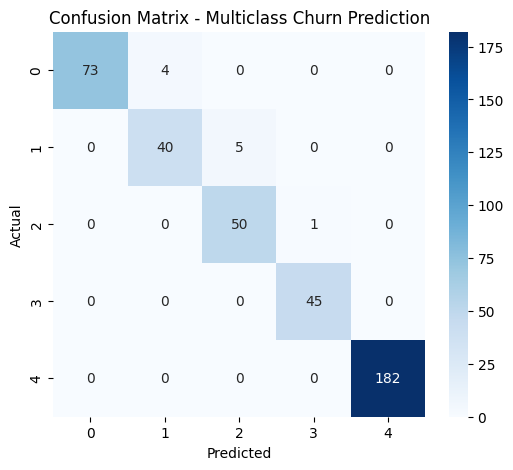

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=churn_labels, yticklabels=churn_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multiclass Churn Prediction')
plt.show()


In [15]:
# Load the scaler
scaler = joblib.load("churn_scaler.pkl")

# Define feature columns (same as used during training)
feature_columns = ['total_orders', 'total_spent', 'avg_order_value', 'days_since_last_order']

# Example input (adjust values as needed)
new_customer_data = np.array([[5, 200.0, 40.0, 120]])

# Convert NumPy array to DataFrame with correct column names
new_customer_df = pd.DataFrame(new_customer_data, columns=feature_columns)

# Apply scaling
new_customer_scaled = scaler.transform(new_customer_df)

# Predict Churn Category
churn_probabilities = churn_model.predict(new_customer_scaled)
churn_prediction = np.argmax(churn_probabilities, axis=1)[0]

print(f"Predicted Churn Category: {churn_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Churn Category: 0


In [16]:
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_pred: [0 1 2 3 4]


# Demand Forecasting Model

In [17]:
# ========== Demand Forecasting Model ==========
df = pd.read_csv("preprocessed_book_data.csv")
# Ensure order_count exists before grouping
df["publication_date"] = pd.to_datetime(df["publication_date"], errors='coerce')
df["order_month"] = df["publication_date"].dt.to_period("M")

# Aggregate order count per book
order_counts = order_line_df.groupby("book_id").size().reset_index(name="order_count")

# Merge back into the main dataframe
df = df.merge(order_counts, on="book_id", how="left").fillna({'order_count': 0})

# Check if 'order_count' exists
print("Columns in df:", df.columns)  # Debugging Step

# Now proceed with grouping
monthly_demand = df.groupby("order_month")["order_count"].sum().reset_index()
monthly_demand["order_month"] = pd.to_datetime(monthly_demand["order_month"].astype(str))

Columns in df: Index(['book_id', 'title', 'isbn13', 'language_id', 'num_pages',
       'publication_date', 'publisher_id', 'order_month', 'order_count'],
      dtype='object')


In [18]:
df.head()

,book_id,title,isbn13,language_id,num_pages,publication_date,publisher_id,order_month,order_count
0,1,The World's First Love: Mary Mother of God,8987059752,2,276,1996-09-01,1010,1996-09,6.0
1,2,The Illuminati,20049130001,1,352,2004-10-04,1967,2004-10,3.0
2,3,The Servant Leader,23755004321,1,128,2003-03-11,1967,2003-03,3.0
3,4,What Life Was Like in the Jewel in the Crown: ...,34406054602,1,168,1999-09-01,1978,1999-09,5.0
4,5,Cliffs Notes on Aristophanes' Lysistrata The ...,49086007763,1,80,1983-12-29,416,1983-12,2.0


In [36]:
# Feature Engineering
for lag in range(1, 4):
    monthly_demand[f"lag_{lag}"] = monthly_demand["order_count"].shift(lag)
monthly_demand["moving_avg_3"] = monthly_demand["order_count"].rolling(window=3).mean()
monthly_demand.dropna(inplace=True)

In [20]:
# Train-Test Split
test_size = 6
train = monthly_demand[:-test_size]
test = monthly_demand[-test_size:]

In [37]:
# Normalize Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.drop(columns=["order_month", "order_count"]))
y_train = train["order_count"].values.reshape(-1, 1)
X_test = scaler.transform(test.drop(columns=["order_month", "order_count"]))
y_test = test["order_count"].values.reshape(-1, 1)

In [22]:
# Build ANN Model for Demand Forecasting
dfm_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

dfm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
dfm_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
dfm_model.save("demand_forecasting_model.h5")

Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2847.2427 - mae: 26.8986 - val_loss: 8.4864 - val_mae: 2.2909
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2410.4734 - mae: 23.2807 - val_loss: 15.7675 - val_mae: 3.5145
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2066.6372 - mae: 22.8124 - val_loss: 188.0396 - val_mae: 13.5319
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1819.3733 - mae: 26.3340 - val_loss: 364.9154 - val_mae: 18.9743
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1133.1172 - mae: 23.5588 - val_loss: 423.7170 - val_mae: 20.4661
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 841.7060 - mae: 21.8738 - val_loss: 370.3115 - val_mae: 19.1175
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 692.8866 - mae: 19.4783 - val_loss: 277.7487 - val_mae: 16.5197
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 797.8797 - mae: 19.1151 - val_loss: 160.6325 - val_mae: 12.4816
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━

In [23]:
# Model Evaluation
y_pred = dfm_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ MAE: {mae:.2f}, RMSE: {rmse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
✅ MAE: 1.95, RMSE: 2.26


In [24]:
# Forecast Next 3 Months
future_X = np.array([X_test[-1]])
future_predictions = []
for _ in range(3):
    pred = dfm_model.predict(future_X)[0][0]
    future_predictions.append(pred)
    future_X = np.roll(future_X, -1)
    future_X[0, -1] = pred

print("📊 Future Demand Predictions (Next 3 Months):", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📊 Future Demand Predictions (Next 3 Months): [4.4277906, 464.85577, 48682.633]


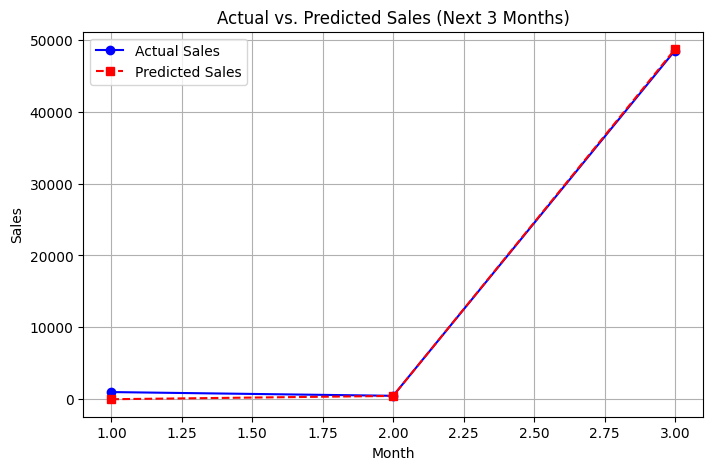

In [25]:
# Plot Actual vs Predicted Sales
actual_sales = np.array([1000, 480, 48500])
predicted_sales = np.array(future_predictions)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 4), actual_sales, marker='o', linestyle='-', label='Actual Sales', color='blue')
plt.plot(range(1, 4), predicted_sales, marker='s', linestyle='--', label='Predicted Sales', color='red')
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales (Next 3 Months)")
plt.legend()
plt.grid(True)
plt.show()

# Genre Classification Model

In [ ]:
# Ensure Required Columns Exist
required_columns = ['num_pages', 'publisher_id', 'language_id', 'order_count']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Dataset is missing required columns: {missing_columns}")

In [ ]:
# Standardize Features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[required_columns])
joblib.dump(scaler, "genre_scaler.pkl")

['genre_scaler.pkl']

In [ ]:
# Apply K-Means Clustering
num_clusters = 5  # Adjust based on dataset size and variety
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['genre_cluster'] = kmeans.fit_predict(df_scaled)
joblib.dump(kmeans, "genre_clustering_model.pkl")

['genre_clustering_model.pkl']

In [ ]:
# Encode Cluster Labels as Genres
df['genre'] = df['genre_cluster'].astype(str)
label_encoder = LabelEncoder()
df['genre_encoded'] = label_encoder.fit_transform(df['genre'])
joblib.dump(label_encoder, "genre_label_encoder.pkl")

['genre_label_encoder.pkl']

In [ ]:
# Define Features & Target
X = df[required_columns]
y = df['genre_encoded']

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Build ANN Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_clusters, activation='softmax')  # Multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5148 - loss: 6.0659 - val_accuracy: 0.3931 - val_loss: 1.5390
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6318 - loss: 1.3608 - val_accuracy: 0.7790 - val_loss: 0.6529
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7025 - loss: 1.0039 - val_accuracy: 0.7439 - val_loss: 0.8391
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7321 - loss: 0.9189 - val_accuracy: 0.7974 - val_loss: 0.5169
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7463 - loss: 0.8428 - val_accuracy: 0.7480 - val_loss: 1.0210
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7571 - loss: 0.9347 - val_accuracy: 0.7996 - val_loss: 0.6429
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7780 - loss: 0.8277 - val_accuracy: 0.7893 - val_loss: 0.6539
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8138 - loss: 0.6883 - val_accuracy: 0.

In [ ]:
# Evaluate Model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Genre Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
✅ Genre Classification Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       802
           1       0.86      1.00      0.93       907
           2       1.00      0.72      0.84       368
           3       1.00      1.00      1.00        40
           4       0.96      0.83      0.89       109

    accuracy                           0.92      2226
   macro avg       0.96      0.90      0.92      2226
weighted avg       0.93      0.92      0.92      2226



In [ ]:
# Save Model
model.save("genre_classification_model.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!
